### Import Libraries

In [1]:
#Generic import Cell
import torch
from torch.autograd import Variable
import numpy as np
import sys
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.gridspec import GridSpec
from time import time
import re
import json
import astropy
from astropy.stats import histogram
from scipy import stats
import astropy.units as u
import astropy.constants as constant
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.units import dimensionless
import pandas as pd
import tqdm as tqdm
from tqdm import tqdm
import importlib
print(f'Pytorch version {torch.__version__}')

Pytorch version 2.0.1


In [2]:
sys.path.append('../scripts/')
import potential_torch
import flow_torch
import toy_systems

Pytorch version 2.0.1
Pytorch version 2.0.1


### Define Parameters

In [3]:
potential_type = 'plummer' #used to select potential {'plummer','?'}
unit_type = 'dimensionless' #used to select units {'galactic','dimensionless'}
orbited = False

G, M, b = 1, 1, 1
#G = constant.G.to(u.kpc*u.km**2/u.solMass/u.s**2)/(u.kpc*u.km**2/u.solMass/u.s**2) #Gravitonal Constant in desired units
#M = 1e4 #Total Mass of the System
#b = 1.5 #Scale Radius
m = 1 #Mass of a typical particle

np.save('G',G)
np.save('M',M)
np.save('b',b)

#Lambda functions for various potentials {KE ,PE, qpdf, vdlytic, vesc}
if potential_type == 'plummer':
    PE = lambda G, M, b, r : -(G*M) / (b**2 + r**2)**(1/2) #Potential Energy
    KE =  lambda m, v : (m/2)*(v**2) #Kinetic Energy
    qpdf = lambda q: ((7*np.pi)/512)*np.square(q)*np.power(np.subtract(1,np.square(q)),7/2) #Normalized velocity probability distribution function
    vdlytic = lambda G, M, b, r : np.sqrt(G*M/(6*np.sqrt(b**2+r**2))) #Analytic velocity dispersion
    vesc = lambda G, M, b, r: np.sqrt(2*G*M/np.sqrt(b**2+np.square(r))) #Escape velocity
    df_norm = lambda G, M, b: (24 * b**2 * np.sqrt(2.) ) / (7. * G**5 * M**4 * np.pi**3) #Normalization for distibution function

if potential_type == '?':
    print('Update these definitions')

#Generates mock data for an idealized plummer sphere.
plummer_sphere = toy_systems.PlummerSphere(G,M,b)
def sample_df(n_samples, max_dist=None):
    """
    Returns phase-space locations sampled from the Plummer sphere
    distribution function. The shape of the output is
    (n_samples, 6).
    """
    #Generates coordinates in phase-space from that lie in a spherical spatial region.
    x,v = plummer_sphere.sample_df(n_samples)
    if max_dist is not None:
        r2 = np.sum(x**2, axis=1)
        idx = (r2 < max_dist**2)
        x = x[idx]
        v = v[idx]
    
    return torch.cat([torch.Tensor(x.astype('f4')), torch.Tensor(v.astype('f4'))], axis=1) , x , v

### Generate Mock Data

In [4]:
#Generates mock data from Plummer Sphere Toy_system
runcell = True
if runcell == True:
    n_samples = 10000
    data, q, p = sample_df(n_samples)
    print('Generating mock plummer data with ' + str(n_samples) + ' samples using G = ' + str(G) + ', M = ' + str(M) + ', and b = ' + str(b))
    #f = np.load('f.npy') + 1
    #f = np.save('f',f)
    #f_name = 'G' + str(G) + '_M' + str(M) + '_b' + str(b) + '_n' + str(n_samples) + '_f' + str(np.load('f.npy')) + '.csv'
    #pd.DataFrame(data).to_csv(f'/Users/andyhicks/DYNAMITE/Data Set/'+ f_name)
    #print('saving as ' + f_name)


Generating mock plummer data with 10000 samples using G = 1, M = 1, and b = 1


### Plot Stationary Orbit

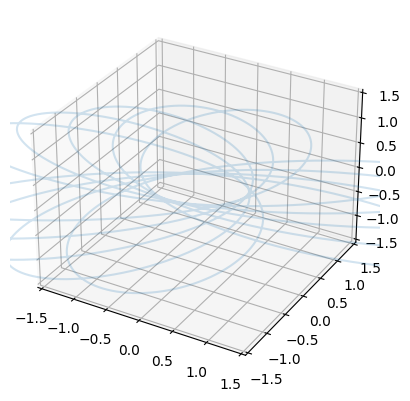

In [42]:
n_i = 22 #Selects which particle trajectory will be modeled
x0,v0 = q[n_i],p[n_i]
j = 0
if unit_type == 'galactic':
    if potential_type == 'plummer':
        potential = gp.PlummerPotential(m = M*u.solMass,b= 1.5*u.kpc, units = galactic)
    w0 = gd.PhaseSpacePosition(pos=x0*u.kpc,vel=v0*u.km/u.s)
    orbit = potential.integrate_orbit(w0, dt=1*u.Myr, t1=0, t2=1*u.Gyr)
    ax = plt.axes(projection='3d')
    ax.plot3D(orbit.x, orbit.y, orbit.z)

if unit_type == 'dimensionless':
    if potential_type == 'plummer':
        potential = gp.PlummerPotential(m = 1,b=b, units = dimensionless)
    w0 = gd.PhaseSpacePosition(pos=x0,vel=v0)
    orbit = potential.integrate_orbit(w0, dt=.01, t1=0, t2=300)
    ax = plt.axes(projection='3d')
    ax.plot3D(orbit.x, orbit.y, orbit.z, alpha = .2)
    ax.scatter3D(orbit.x[j], orbit.y[j], orbit.z[j], alpha = 1, c= 'maroon', s = 300)
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.set_zlim(-1.5,1.5)
    #ax.axis(False)

### Animate the Orbit

In [39]:
### Clears Film memory for new movie with different length
runcell = False
if runcell == True:

    import os
    import glob

    files = glob.glob('/Users/andyhicks/DYNAMITE/Film/*')
    for f in files:
        os.remove(f)

In [43]:
for j in tqdm(range(1,1000)):
    su = 10
    T = j*su
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.plot3D(orbit[0:T].x, orbit[0:T].y, orbit[0:T].z, alpha = .2)
    ax.scatter3D(orbit.x[T], orbit.y[T], orbit.z[T], alpha = 1, c= 'maroon', s = 300)
    ax.set_title('Single Orbit')
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.set_zlim(-1.5,1.5)
    # Set axes label
    fig.savefig('/Users/andyhicks/DYNAMITE/Film/' + str(j))
    plt.close(fig)

  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 999/999 [03:56<00:00,  4.23it/s]


In [27]:
orbit1 = orbit

In [45]:
print(orbit3)

pos=[(-3.14631179, -2.24141965,  0.31477723),
 (-3.14603511, -2.24341227,  0.31532621),
 (-3.14575352, -2.24540139,  0.3158747 ), ...,
 ( 2.23931956,  3.20618838, -0.6482671 ),
 ( 2.23797077,  3.20733386, -0.64868686),
 ( 2.2366187 ,  3.20847464, -0.64910568)] 
vel=[( 0.02742348, -0.19943673,  0.05492281),
 ( 0.02791387, -0.1990872 ,  0.05487371),
 ( 0.02840387, -0.19873762,  0.05482455), ...,
 (-0.13471551,  0.11478234, -0.0420239 ),
 (-0.13504308,  0.11431311, -0.04192901),
 (-0.13537041,  0.11384378, -0.04183408)] 


In [39]:
orbit2 = orbit

In [43]:
orbit3 = orbit

In [47]:
for j in tqdm(range(0,3000)):
    su = 10
    T = j*su
    gridm = 3
    fig = plt.figure(figsize=plt.figaspect(0.5))
    # =============
    # First subplot
    # =============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.plot3D(orbit1[0:T].x, orbit1[0:T].y, orbit1[0:T].z, alpha = .2, c='maroon')
    ax.scatter3D(orbit1.x[T], orbit1.y[T], orbit1.z[T], alpha = 1, c='maroon' , s = 100)
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.set_zlim(-1.5,1.5)
    # ==============
    # Second subplot
    # ==============
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 3, 2, projection='3d')

    # plot a 3D wireframe like in the example mplot3d/wire3d_demo
    ax.plot3D(orbit2[0:T].x, orbit2[0:T].y, orbit2[0:T].z, alpha = .2, c='navy')
    ax.scatter3D(orbit2.x[T], orbit2.y[T], orbit2.z[T], alpha = 1, c='navy', s = 100)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)

    ax = fig.add_subplot(1, 3, 3, projection='3d')

    # plot a 3D wireframe like in the example mplot3d/wire3d_demo
    ax.plot3D(orbit3[0:T].x, orbit3[0:T].y, orbit3[0:T].z, alpha = .2, c='forestgreen')
    ax.scatter3D(orbit3.x[T], orbit3.y[T], orbit3.z[T], alpha = 1, c='forestgreen' , s = 100)
    ax.set_xlim(-gridm,gridm)
    ax.set_ylim(-gridm,gridm)
    ax.set_zlim(-gridm,gridm)
    
    fig.savefig('/Users/andyhicks/DYNAMITE/Film/' + str(j))
    plt.close(fig)




100%|██████████| 3000/3000 [25:28<00:00,  1.96it/s]  


### Same as above but for multiple orbits

In [ ]:
potential = gp.PlummerPotential(m = 1,b=b, units = dimensionless)

n_1, n_2, n_3, n_4, n_5 = np.random.randint(0,len(q),5)
#n_1, n_2, n_3, n_4, n_5 = 1,2,3,4,5
psize1, psize2, psize3, psize4, psize5 = np.random.randint(50,500,5)
#psize1, psize2, psize3, psize4, psize5 = 300,300,300,300,300
c1, c2, c3, c4, c5 = 'maroon', 'navy', 'forestgreen' , 'violet', 'purple'

dT = .01
su = 10
T = 500*10*dT
gridm = 3

x1,v1 = q[n_1],p[n_1]
x2,v2 = q[n_2],p[n_2]
x3,v3 = q[n_3],p[n_3]
x4,v4 = q[n_4],p[n_4]
x5,v5 = q[n_5],p[n_5]

w1 = gd.PhaseSpacePosition(pos=x1,vel=v1)
w2 = gd.PhaseSpacePosition(pos=x2,vel=v2)
w3 = gd.PhaseSpacePosition(pos=x3,vel=v3)
w4 = gd.PhaseSpacePosition(pos=x4,vel=v4)
w5 = gd.PhaseSpacePosition(pos=x5,vel=v5)

orbit1 = potential.integrate_orbit(w1, dt=dT, t1=0, t2=T)
orbit2 = potential.integrate_orbit(w2, dt=dT, t1=0, t2=T)
orbit3 = potential.integrate_orbit(w3, dt=dT, t1=0, t2=T)
orbit4 = potential.integrate_orbit(w4, dt=dT, t1=0, t2=T)
orbit5 = potential.integrate_orbit(w5, dt=dT, t1=0, t2=T)

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')

ax.scatter3D(0,0,0, alpha = .5, c= 'black', s = 50 ,  marker = 'x')
ax.plot3D(orbit1.x, orbit1.y, orbit1.z, alpha = .2, c= c1)
ax.scatter3D(orbit1.x[-1], orbit1.y[-1], orbit1.z[-1], alpha = .8, c= c1, s = psize1)
ax.plot3D(orbit2.x, orbit2.y, orbit2.z, alpha = .2, c= c2)
ax.scatter3D(orbit2.x[-1], orbit2.y[-1], orbit2.z[-1], alpha = .8, c= c2, s = psize2)
ax.plot3D(orbit3.x, orbit3.y, orbit3.z, alpha = .2, c= c3)
ax.scatter3D(orbit3.x[-1], orbit3.y[-1], orbit3.z[-1], alpha = .8, c= c3, s = psize3)
#ax.plot3D(orbit4.x, orbit4.y, orbit4.z, alpha = .2, c= 'violet')
#ax.scatter3D(orbit4.x[-1], orbit4.y[-1], orbit4.z[-1], alpha = 1, c= 'violet', s = psize4)
#ax.plot3D(orbit5.x, orbit5.y, orbit5.z, alpha = .2, c= 'purple')
#ax.scatter3D(orbit5.x[-1], orbit5.y[-1], orbit5.z[-1], alpha = 1, c= 'purple', s = psize5)


ax.set_title('Multple Orbits')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-gridm,gridm)
ax.set_ylim(-gridm,gridm)
ax.set_zlim(-gridm,gridm)


In [ ]:
for j in range(1,500):
    gridm = 1.5
    T = su*j
    fig = plt.figure(figsize=(12,10))
    ax = plt.axes(projection='3d')

    ax.scatter3D(0,0,0, alpha = .5, c= 'black', s = 50, marker = 'x')
    ax.plot3D(orbit1[0:T].x, orbit1[0:T].y, orbit1[0:T].z, alpha = .2, c= c1)
    ax.scatter3D(orbit1.x[T], orbit1.y[T], orbit1.z[T], alpha = .8, c= c1, s = psize1)
    ax.plot3D(orbit2[0:T].x, orbit2[0:T].y, orbit2[0:T].z, alpha = .2, c= c2)
    ax.scatter3D(orbit2.x[T], orbit2.y[T], orbit2.z[T], alpha = .8, c= c2, s = psize2)
    ax.plot3D(orbit3[0:T].x, orbit3[0:T].y, orbit3[0:T].z, alpha = .2, c= c3)
    ax.scatter3D(orbit3.x[T], orbit3.y[T], orbit3.z[T], alpha = .8, c= c3, s = psize3)
    #ax.plot3D(orbit4[0:T].x, orbit4[0:T].y, orbit4.z[0:T], alpha = .2, c= c4)
    #ax.scatter3D(orbit4.x[T], orbit4.y[T], orbit4.z[T], alpha = 1, c= c4, s = psize4)
    #ax.plot3D(orbit5[0:T].x, orbit5[0:T].y, orbit5[0:T].z, alpha = .2, c= c5)
    #ax.scatter3D(orbit5.x[T], orbit5.y[T], orbit5.z[T], alpha = 1, c= c5, s = psize5)
    



    ax.set_title('Multple Orbits')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(-gridm,gridm)
    ax.set_ylim(-gridm,gridm)
    ax.set_zlim(-gridm,gridm)

    fig.savefig('/Users/andyhicks/DYNAMITE/Film/' + str(j))
    plt.close(fig)

### Animates Orbits for all Particles

In [5]:
potential1 = gp.PlummerPotential(m = 1, b=b, units = dimensionless)
potential2 = gp.MilkyWayPotential()
w0 = gd.PhaseSpacePosition(pos=q.T,vel=p.T)
orbit1 = potential1.integrate_orbit(w0, dt=.01, t1=0, t2=100)
orbit2 = potential2.integrate_orbit(w0, dt =.01, t1 =0, t2 = 100)

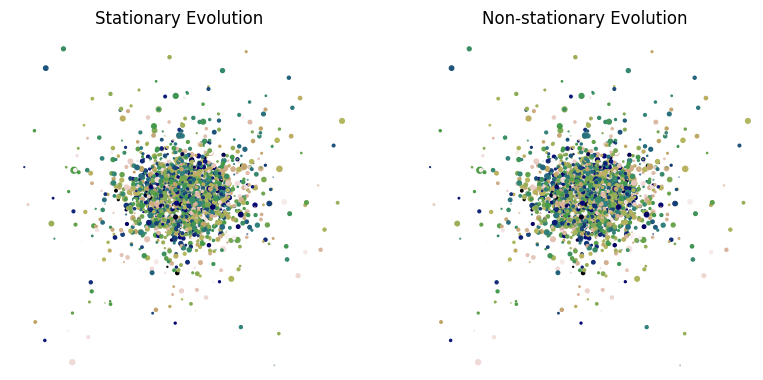

In [6]:
##
j = 0
gridm = 8
su = 10
colors = np.arange(n_samples)
sizes = abs(np.random.normal(1,5,n_samples))

fig = plt.figure(figsize=plt.figaspect(0.5))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(orbit1.x[j], orbit1.y[j], orbit1.z[j], alpha = 1, c= colors , s = sizes, cmap = 'gist_earth_r')
ax.set_xlim(-gridm,gridm)
ax.set_ylim(-gridm,gridm)
ax.set_zlim(-gridm,gridm)
ax.set_title('Stationary Evolution')
ax.grid(False)
ax.axis(False)
# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
ax.scatter3D(orbit2.x[j], orbit2.y[j], orbit2.z[j], alpha = 1, c= colors , s = sizes, cmap = 'gist_earth_r')
ax.set_xlim(-gridm,gridm)
ax.set_ylim(-gridm,gridm)
ax.set_zlim(-gridm,gridm)
ax.set_title('Non-stationary Evolution')
ax.grid(False)
ax.axis(False)
plt.show()

In [7]:
for j in tqdm(range(1,1000)):
    T = su*j

    fig = plt.figure(figsize=plt.figaspect(0.5))
    # =============
    # First subplot
    # =============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter3D(orbit1.x[T], orbit1.y[T], orbit1.z[T], alpha = 1, c= colors , s = sizes, cmap = 'gist_earth_r')
    ax.set_xlim(-gridm,gridm)
    ax.set_ylim(-gridm,gridm)
    ax.set_zlim(-gridm,gridm)
    ax.set_title('Stationary Evolution')
    ax.grid(False)
    ax.axis(False)
    # ==============
    # Second subplot
    # ==============
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')

    # plot a 3D wireframe like in the example mplot3d/wire3d_demo
    ax.scatter3D(orbit2.x[T], orbit2.y[T], orbit2.z[T], alpha = 1, c= colors , s = sizes, cmap = 'gist_earth_r')
    ax.set_xlim(-gridm,gridm)
    ax.set_ylim(-gridm,gridm)
    ax.set_zlim(-gridm,gridm)
    ax.set_title('Non-stationary Evolution')
    ax.grid(False)
    ax.axis(False)
        
    fig.savefig('/Users/andyhicks/DYNAMITE/Film/' + str(j))
    plt.close(fig)

100%|██████████| 999/999 [09:37<00:00,  1.73it/s]
